In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    # compute power
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    # edge distances
    n_edges = len(G.edges)
    distance = np.random.uniform(low=1, high=3, size=n_edges)
    for (a, b) in G.edges:
        G.edges[a, b]["distance"] = distance[i]  # BUG! i is not defined
        G.edges[a, b]["delay"] = f"uniform {distance[i] * 0.5} {distance[i] * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / distance[i]
    distances = dict(nx.shortest_path_length(G, weight="distance"))
    # closeness / farness metrics
    node_attr = dict()
    for i, d in distances.items():
        farness = sum(d.values()) / (n - 1)
        compute_farness = sum([G.nodes[j]["compute"] * d for j, d in d.items()])
        node_attr[i] = dict(
            farness=farness,
            closeness=1 / farness,
            compute_farness=compute_farness,
            compute_closeness=1 / compute_farness,
        )
    nx.set_node_attributes(G, node_attr)
    # done
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000):
    G = G.copy()
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    with subprocess.Popen(
        ["dune", "exec", "simulator/bin/igraph_runner.exe"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        return nx.parse_graphml(out)


def draw(G, size="compute", layout=None):
    G = G.copy()
    size = nx.get_node_attributes(G, size).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [3]:
G = barabasi_albert(n=7)
pd.DataFrame.from_dict(G.nodes, orient="index")

,compute,farness,closeness,compute_farness,compute_closeness
0,0.356308,1.787419,0.559466,1.150548,0.869151
1,0.214698,2.979032,0.335680,2.068568,0.483426
2,0.200887,2.681128,0.372977,2.081858,0.480340
3,0.073590,2.979032,0.335680,2.638811,0.378958
4,0.077327,2.681128,0.372977,2.523563,0.396265
5,0.057002,2.383225,0.419599,1.853151,0.539621
6,0.020188,2.383225,0.419599,2.236978,0.447032


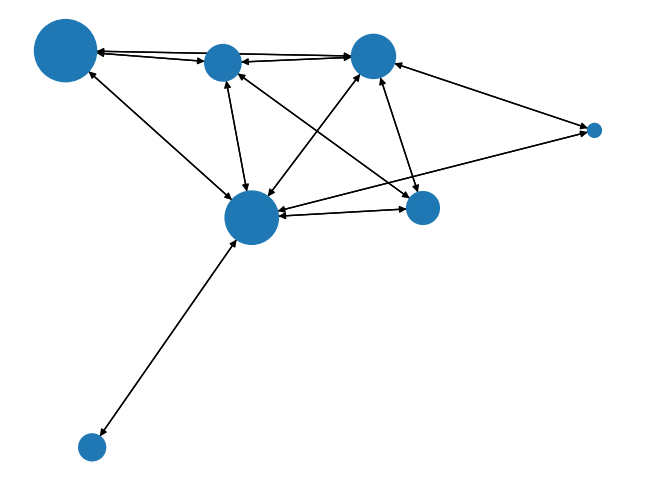

In [4]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=10000)
layout = draw(G)

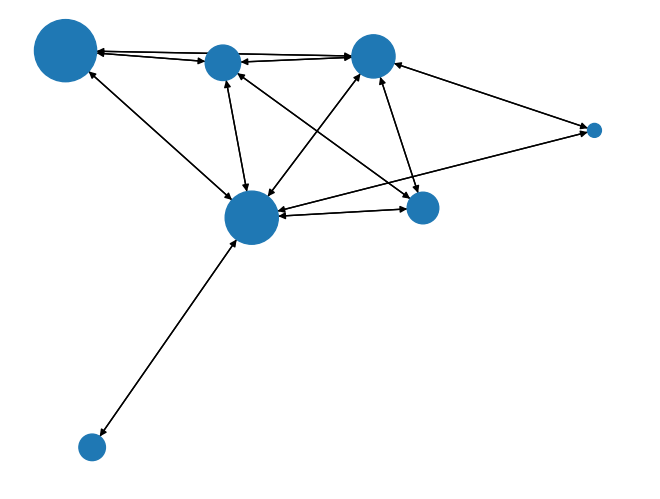

In [5]:
draw(G, size="activations", layout=layout)

In [6]:
runs = []
for _ in range(10):
    net = barabasi_albert(n=7)
    cf = dict(G.nodes(data="compute_farness")).values()
    est_progagation_delay = sum(cf) / len(cf)
    for p in [
        "nakamoto",
        "ethereum-discount",
        "tailstorm-8-constant-heuristic",
        "tailstorm-8-discount-optimal",
    ]:
        G = sim(
            net,
            activation_delay=2 * est_progagation_delay,
            activations=1000,
            protocol=p,
        )
        d = pd.DataFrame.from_dict(G.nodes, orient="index")
        d["protocol"] = p
        runs.append(d)
df = pd.concat(runs)
# calculate metrics
df["relative_reward"] = df.reward / np.sum(df.reward)
df["relative_activations"] = df.reward / np.sum(df.activations)
df["efficiency"] = df.reward / G.graph["head_progress"] / df.compute
df.efficiency.fillna(0, inplace=True)
display(df)

,activations,reward,compute_closeness,compute_farness,closeness,farness,compute,protocol,relative_reward,relative_activations,efficiency
n0,398.0,348.000,0.684474,1.460976,0.410478,2.436186,0.400302,nakamoto,0.010455,0.008700,0.898082
n1,86.0,25.000,0.289074,3.459321,0.223897,4.466342,0.089862,nakamoto,0.000751,0.000625,0.287401
n2,154.0,82.000,0.364238,2.745459,0.246287,4.060311,0.144452,nakamoto,0.002464,0.002050,0.586430
n3,32.0,17.000,0.304104,3.288345,0.273652,3.654279,0.028135,nakamoto,0.000511,0.000425,0.624203
n4,125.0,60.000,0.366879,2.725691,0.273652,3.654279,0.143614,nakamoto,0.001803,0.001500,0.431599
...,...,...,...,...,...,...,...,...,...,...,...
n2,522.0,432.625,0.539251,1.854425,0.251982,3.968532,0.518574,tailstorm-8-discount-optimal,0.012998,0.010816,0.861837
n3,142.0,109.125,0.275253,3.633026,0.279980,3.571678,0.138808,tailstorm-8-discount-optimal,0.003279,0.002728,0.812144
n4,144.0,107.000,0.256114,3.904508,0.229075,4.365385,0.126811,tailstorm-8-discount-optimal,0.003215,0.002675,0.871671
n5,68.0,53.250,0.400215,2.498660,0.359975,2.777972,0.077447,tailstorm-8-discount-optimal,0.001600,0.001331,0.710295


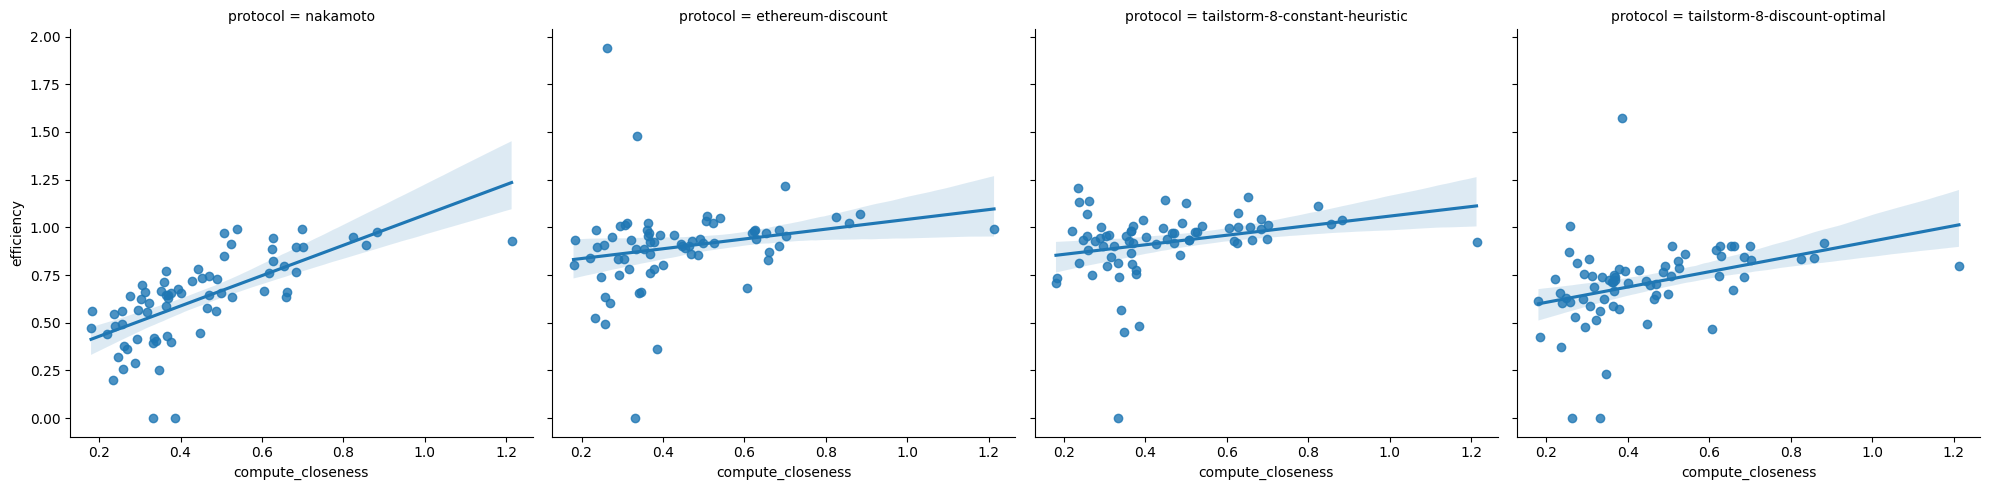

In [7]:
sns.lmplot(data=df, x="compute_closeness", y="efficiency", col="protocol")

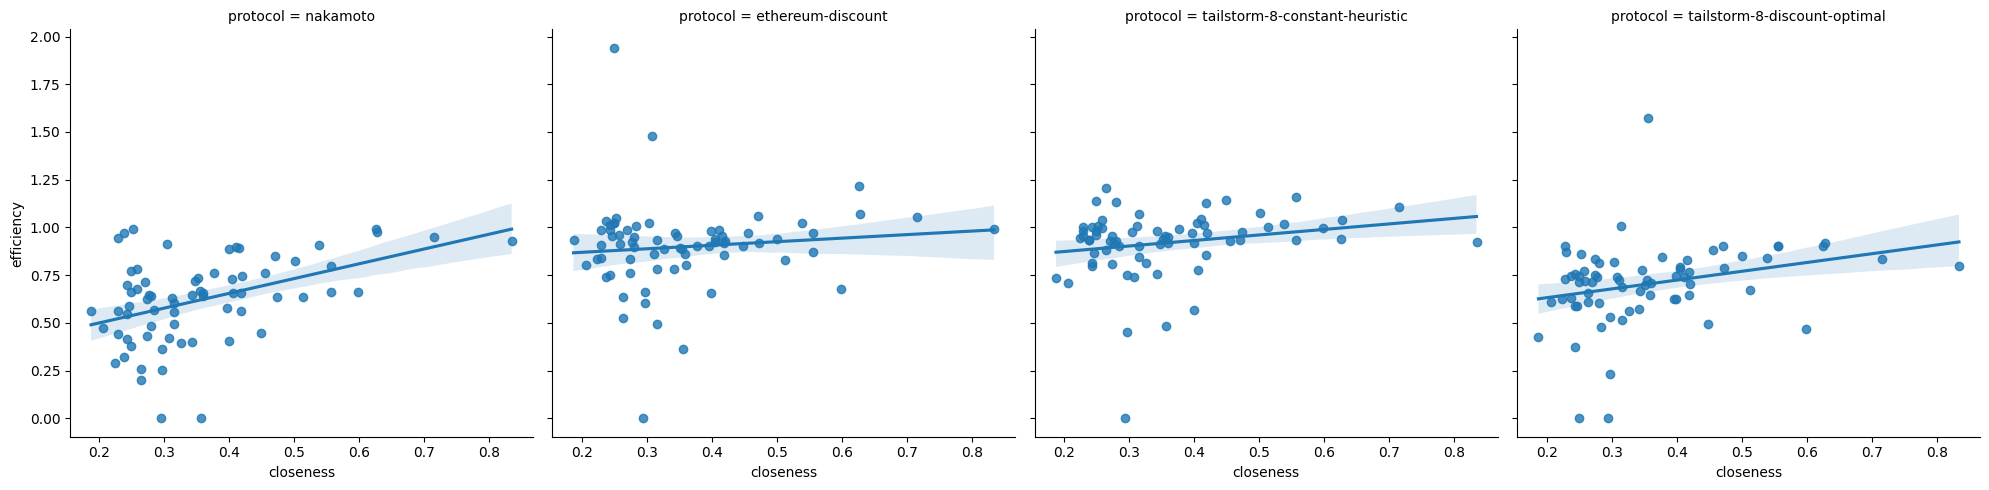

In [8]:
sns.lmplot(data=df, x="closeness", y="efficiency", col="protocol")